In [1]:
# !pip install tensorflow

In [2]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import ipywidgets as widgets
import nltk
nltk.download('stopwords')
from plotly.offline import init_notebook_mode
from ipywidgets import interact, interactive, fixed, interact_manual
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elcor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
init_notebook_mode(connected = True)

In [4]:
data = pd.read_csv('train.csv')
data.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


# SPLITS

In [5]:
df, validation_df  = train_test_split(data,
                                test_size=0.25,
                                random_state = 101)

In [6]:
df_train, df_test  = train_test_split(df,
                                test_size=0.25,
                                random_state = 101)

# EDA

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41687 entries, 17236 to 68913
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      41687 non-null  int64  
 1   log_price               41687 non-null  float64
 2   property_type           41687 non-null  object 
 3   room_type               41687 non-null  object 
 4   amenities               41687 non-null  object 
 5   accommodates            41687 non-null  int64  
 6   bathrooms               41571 non-null  float64
 7   bed_type                41687 non-null  object 
 8   cancellation_policy     41687 non-null  object 
 9   cleaning_fee            41687 non-null  bool   
 10  city                    41687 non-null  object 
 11  description             41687 non-null  object 
 12  first_review            32697 non-null  object 
 13  host_has_profile_pic    41573 non-null  object 
 14  host_identity_verified  41573 non-

In [8]:
df_train.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,4.168700e+04,41687.000000,41687.000000,41571.000000,41687.000000,41687.000000,41687.000000,32248.000000,41644.000000,41620.000000
mean,1.126008e+07,4.781785,3.143642,1.232554,38.462137,-92.280070,20.812963,94.114953,1.264792,1.706007
std,6.083368e+06,0.717077,2.134425,0.574109,3.078110,21.685129,37.785910,7.741383,0.847086,1.242858
min,3.440000e+02,0.000000,1.000000,0.000000,33.340916,-122.511500,0.000000,20.000000,0.000000,1.000000
25%,6.268097e+06,4.317488,2.000000,1.000000,34.129931,-118.341316,1.000000,92.000000,1.000000,1.000000
50%,1.223036e+07,4.700480,2.000000,1.000000,40.664508,-76.992899,6.000000,96.000000,1.000000,1.000000
75%,1.641251e+07,5.220356,4.000000,1.000000,40.746488,-73.954371,23.000000,100.000000,1.000000,2.000000
max,2.123090e+07,7.600402,16.000000,8.000000,42.390437,-70.985047,530.000000,100.000000,10.000000,16.000000


C:\Users\elcor\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



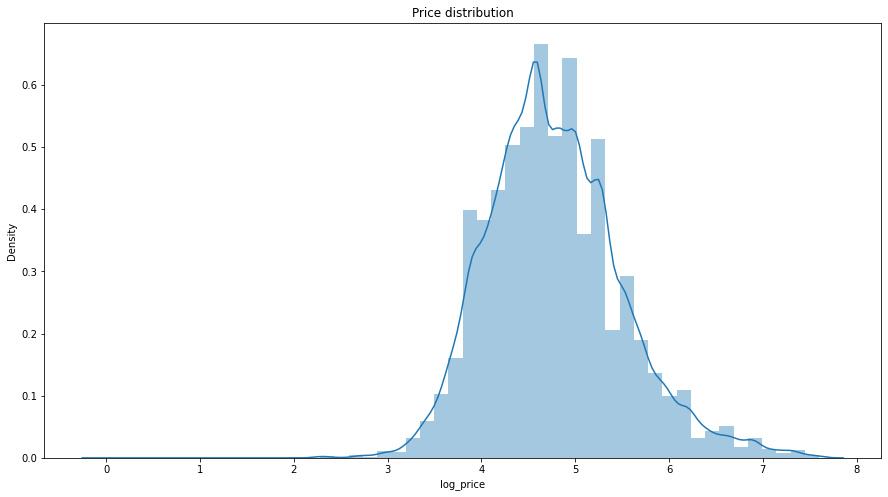

C:\Users\elcor\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



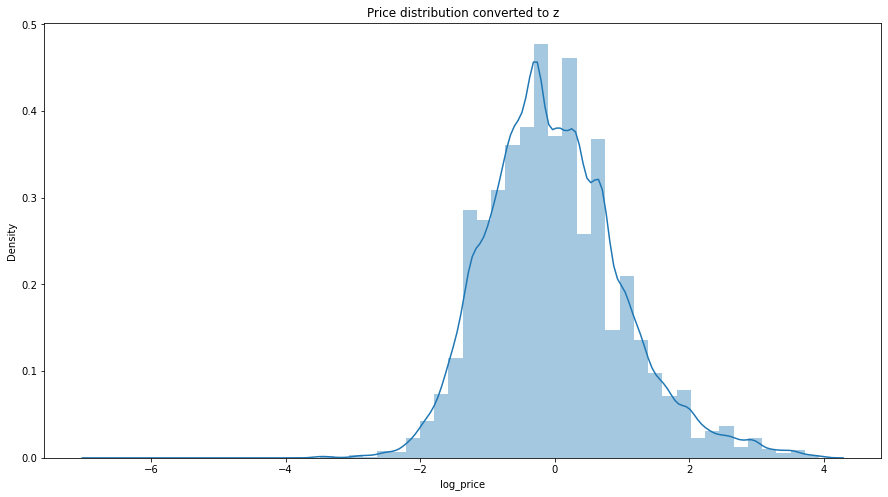

In [9]:
plt.figure(figsize = (15, 8))
sns.distplot(df_train['log_price'])
plt.title('Price distribution')
plt.show()

plt.figure(figsize = (15, 8))
sns.distplot((df_train['log_price']-np.mean(df_train['log_price'])) / np.std(df_train['log_price']))
plt.title('Price distribution converted to z')
plt.show()

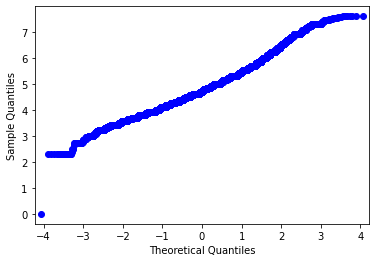

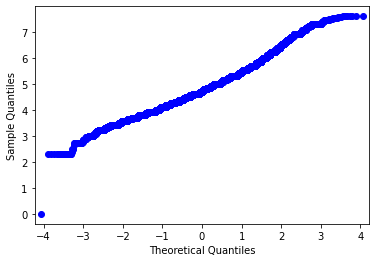

In [10]:
#qqplot
qqplot(df_train['log_price'])

# Looks like price distribution is roughly Gaussian

In [11]:
df_train[df_train['bedrooms'] == 0].head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
34202,6292490,6.214608,Loft,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",""Wheel...",16,1.0,Real Bed,strict,True,LA,"The studio features 35' ceilings, 3 skylights,...",2016-07-24,t,t,95%,2016-05-24,t,2017-04-09,34.069558,-118.227982,"Event Space w/ FREE Parking, No Noise Restrict...",NaN,28,93.0,https://a0.muscache.com/im/pictures/9e64020e-2...,90012,0.0,1.0
2941,9158651,4.820282,Loft,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",3,1.0,Real Bed,strict,True,LA,Close to LA Live and numerous Downtown enterta...,2016-10-30,t,t,100%,2014-06-16,t,2017-04-18,34.044590,-118.254967,Downtown Luxury Loft in Historic Building,Downtown,27,97.0,https://a0.muscache.com/im/pictures/dbb37a1c-c...,90014,0.0,1.0
33759,17367369,4.553877,Apartment,Entire home/apt,"{Internet,""Wireless Internet"",""Air conditionin...",2,1.0,Real Bed,strict,False,DC,My peaceful abode is close to Columbia Heights...,2016-07-29,t,f,NaN,2016-07-23,f,2016-10-23,38.930792,-77.034696,"Peaceful, Sunny Studio in Columbia Heights",Columbia Heights,7,94.0,https://a0.muscache.com/im/pictures/b4b71f63-3...,20010,0.0,1.0
67348,2183423,4.521789,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,1.0,Real Bed,strict,True,LA,"King Sized Bed, Plasma TV, Cable, Internet Bat...",2014-06-22,t,t,60%,2014-06-09,f,2017-04-09,34.104367,-118.339982,"Studio in Hollywood,Parking",Hollywood,87,86.0,NaN,90028,0.0,1.0
19001,16029649,4.174387,Apartment,Entire home/apt,"{Internet,""Wireless Internet"",""Air conditionin...",2,1.0,Real Bed,moderate,True,LA,My apartment is amazing. The building is extr...,2015-10-15,t,t,100%,2015-09-03,f,2016-10-17,34.046298,-118.312926,Huge Studio with Extra Dining room,Mid-City,9,91.0,https://a0.muscache.com/im/pictures/108460096/...,90019,0.0,1.0


<AxesSubplot:>

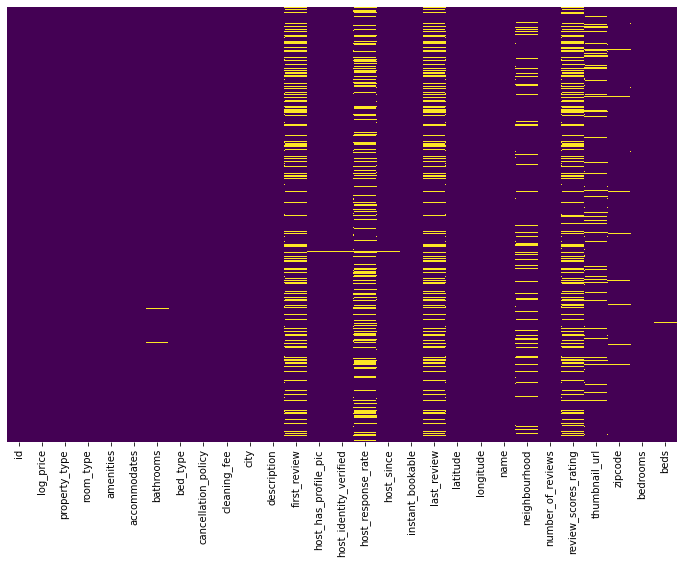

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# Columns with a lot of missing data:

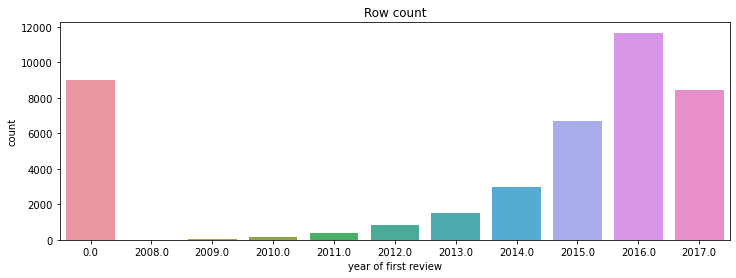

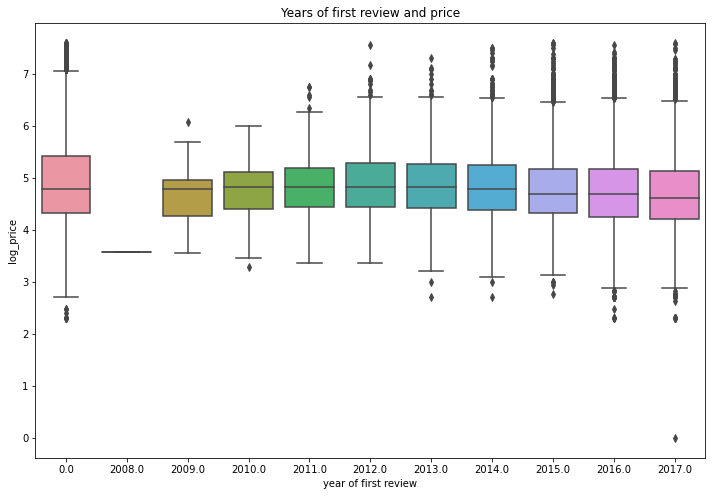

In [13]:
years_of_first_review = pd.DataFrame({
    'year of first review':pd.to_datetime(df_train['first_review'], format='%Y-%m-%d', errors='coerce').dt.year.fillna(0),
    'log_price': df_train['log_price']
})
plt.figure(figsize=(12,4))

sns.countplot(x="year of first review", data=years_of_first_review)
plt.title('Row count')
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot(data=years_of_first_review,orient='v', x = 'year of first review', y = 'log_price')
plt.title('Years of first review and price')
plt.show()

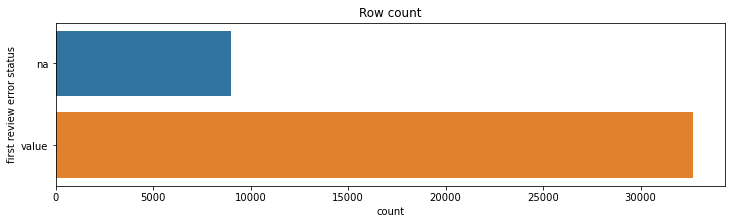

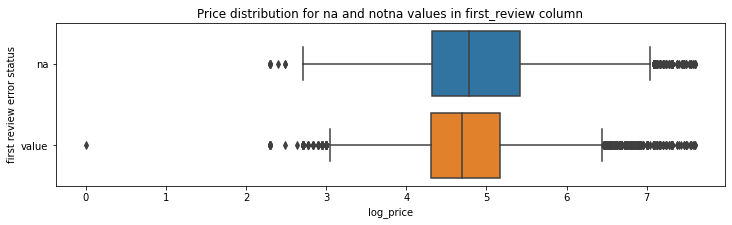

In [14]:
na_or_not = lambda x: 'na' if x else 'value'

first_review_error_status= pd.DataFrame({
    'first review error status':df_train['first_review'].isna().apply(na_or_not),
    'log_price': df_train['log_price']
})

plt.figure(figsize=(12,3))
sns.countplot(y='first review error status', data=first_review_error_status, orient='h')
plt.title('Row count')
plt.show()

plt.figure(figsize=(12,3))
sns.boxplot(data=first_review_error_status,orient='h', y = 'first review error status', x = 'log_price')
plt.title('Price distribution for na and notna values in first_review column')
plt.show()

<Figure size 720x360 with 0 Axes>

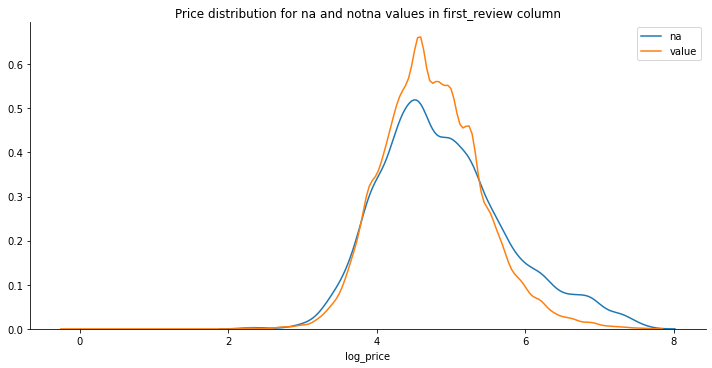

In [15]:
plt.figure(figsize=(10,5))
g = sns.FacetGrid(first_review_error_status, hue="first review error status", height = 5, aspect = 2)
g.map(sns.kdeplot, "log_price")
plt.legend()
plt.title('Price distribution for na and notna values in first_review column')
plt.show()

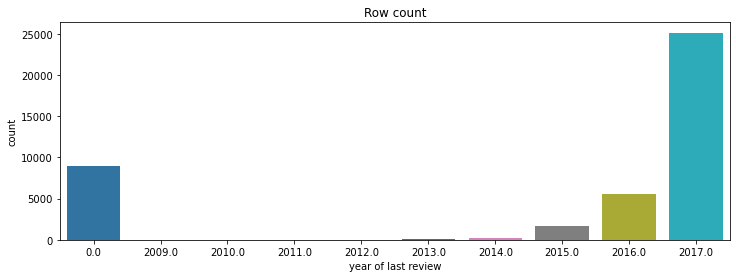

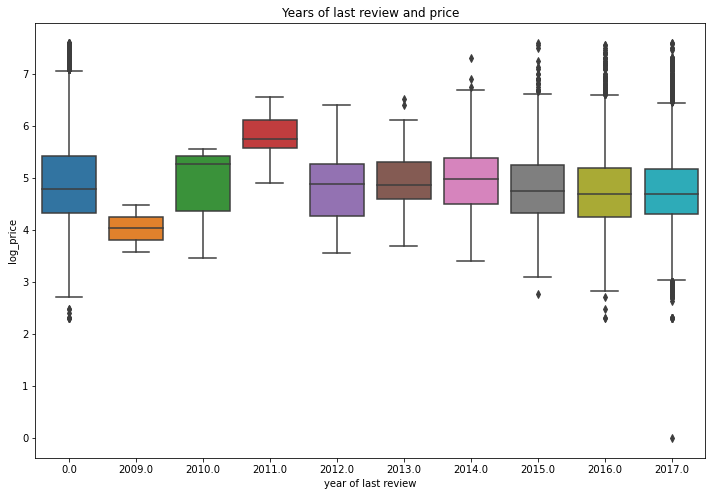

In [16]:
years_of_last_review = pd.DataFrame({
    'year of last review':pd.to_datetime(df_train['last_review'], format='%Y-%m-%d', errors='coerce').dt.year.fillna(0),
    'log_price': df_train['log_price']
})

plt.figure(figsize=(12,4))
sns.countplot(x="year of last review", data=years_of_last_review)
plt.title('Row count')
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot(data=years_of_last_review,orient='v', x = 'year of last review', y = 'log_price')
plt.title('Years of last review and price')
plt.show()

In [17]:
popular_property_types = list(df_train['property_type'].value_counts()[df_train['property_type'].value_counts() > 50].index)
popular_property_types

['Apartment',
 'House',
 'Condominium',
 'Townhouse',
 'Loft',
 'Other',
 'Guesthouse',
 'Bed & Breakfast',
 'Bungalow',
 'Villa',
 'Dorm',
 'Guest suite',
 'Camper/RV']

In [18]:
df_train['room_type'].value_counts()

Entire home/apt    23233
Private room       17235
Shared room         1219
Name: room_type, dtype: int64

In [19]:
df_train['bed_type'].value_counts()

Real Bed         40461
Futon              453
Pull-out Sofa      343
Airbed             263
Couch              167
Name: bed_type, dtype: int64

In [20]:
df_train['cancellation_policy'].value_counts()
popular_cancellation_policy = list(df_train['cancellation_policy'].value_counts()[df_train['cancellation_policy'].value_counts() > 100].index)
popular_cancellation_policy

['strict', 'flexible', 'moderate']

In [21]:
df_train['city'].value_counts()

NYC        18296
LA         12554
SF          3590
DC          3176
Chicago     2093
Boston      1978
Name: city, dtype: int64

In [22]:
df_train['host_response_rate'].value_counts()

100%    24387
90%      1286
80%       647
0%        506
50%       327
        ...  
23%         1
6%          1
41%         1
22%         1
27%         1
Name: host_response_rate, Length: 76, dtype: int64

In [23]:
df_train['review_scores_rating'].value_counts()

100.0    9093
98.0     2498
96.0     2336
97.0     2292
95.0     2124
93.0     2027
90.0     1568
99.0     1486
94.0     1463
80.0     1225
92.0     1182
91.0      887
87.0      624
89.0      623
88.0      598
85.0      341
86.0      298
84.0      239
60.0      234
83.0      223
70.0      118
82.0      111
73.0       82
81.0       80
78.0       56
75.0       51
20.0       51
40.0       46
79.0       44
77.0       44
67.0       37
76.0       30
72.0       22
74.0       22
50.0       19
65.0       12
71.0        9
68.0        9
69.0        9
63.0        7
64.0        7
53.0        6
47.0        2
27.0        2
55.0        2
57.0        2
30.0        2
66.0        1
56.0        1
54.0        1
62.0        1
35.0        1
Name: review_scores_rating, dtype: int64

In [24]:
df_train[df_train['bathrooms'].isna()].head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
22225,16384358,4.077537,Apartment,Private room,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,NaN,Real Bed,strict,False,NYC,15 min from the city!!! nice loft space apartm...,2013-09-28,t,f,100%,2012-06-14,f,2015-12-02,40.701396,-73.913335,Nice private space in Bklyn loft!,Bushwick,12,92.0,https://a0.muscache.com/im/pictures/6499936/af...,11237,1.0,1.0
10556,7682094,3.871201,Apartment,Private room,{},1,NaN,Real Bed,flexible,True,NYC,Massive 400 sq ft Bedroom in beautifully renov...,2015-03-31,t,f,NaN,2012-07-10,f,2015-03-31,40.710993,-73.952170,Huge Bdrm in New Wilibrg 3 Bed Loft,Williamsburg,1,80.0,https://a0.muscache.com/im/pictures/7324290/50...,11211,1.0,NaN
2842,12130093,4.382027,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,NaN,Futon,moderate,False,Chicago,This is a very small studio apartment with a ...,2009-07-03,t,f,100%,2009-05-19,f,2017-05-02,41.902845,-87.681830,Tiny Studio Apartment 94 Walk Score,Ukrainian Village,242,91.0,https://a0.muscache.com/im/pictures/51073/16c8...,60622,NaN,1.0
61508,8668115,4.025352,House,Private room,"{Internet,""Wireless Internet"",Kitchen,""transla...",2,NaN,Real Bed,strict,False,LA,Private Room for rent in Los Angeles. Short-te...,2013-09-07,t,t,96%,2012-05-08,f,2017-02-27,34.032356,-118.299849,Private Room for Rent near USC,West Adams,20,86.0,https://a0.muscache.com/im/pictures/7c98009f-9...,90007,1.0,1.0
24116,7309611,3.784190,Apartment,Private room,"{Internet,""Wireless Internet""}",2,NaN,Real Bed,strict,False,LA,Small Private Room with shared bathroom in Los...,2012-12-31,t,t,96%,2012-05-08,f,2017-03-20,34.042585,-118.346622,LA Boardinghouse - Simple Private Room,Mid-City,30,83.0,https://a0.muscache.com/im/pictures/39736169/e...,90019,1.0,1.0


In [25]:
df_train['bathrooms'].value_counts()

1.0    32751
2.0     4437
1.5     2131
2.5      920
3.0      553
3.5      235
4.0      156
0.5      113
0.0      100
4.5       64
5.0       39
5.5       22
8.0       16
6.0       12
6.5       10
7.0        8
7.5        4
Name: bathrooms, dtype: int64

In [26]:
df_train['host_has_profile_pic'].value_counts()

t    41448
f      125
Name: host_has_profile_pic, dtype: int64

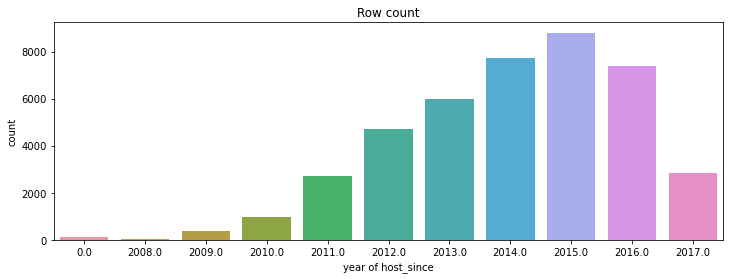

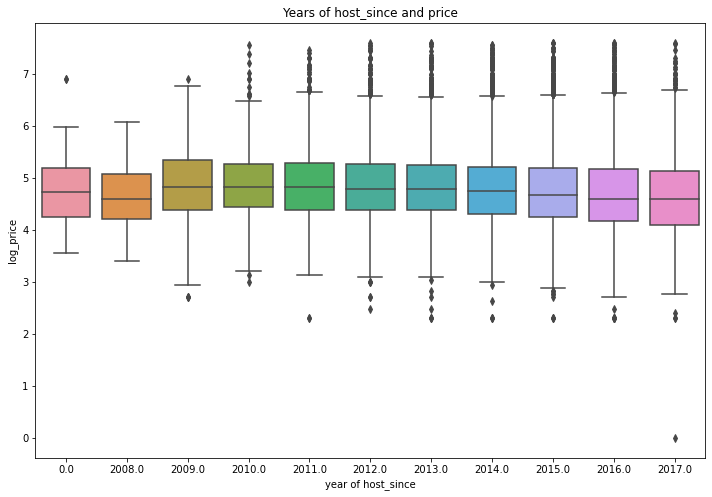

In [27]:
years_of_host_since = pd.DataFrame({
    'year of host_since':pd.to_datetime(df_train['host_since'], format='%Y-%m-%d', errors='coerce').dt.year.fillna(0),
    'log_price': df_train['log_price']
})

plt.figure(figsize=(12,4))
sns.countplot(x="year of host_since", data=years_of_host_since)
plt.title('Row count')
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot(data=years_of_host_since,orient='v', x = 'year of host_since', y = 'log_price')
plt.title('Years of host_since and price')
plt.show()

# Price distribution of na values looks like one for 2008 values. I think, best of worst is to use 2008 value to fill na in this situation.

In [28]:
#map

def create_map(city):
    price_view = lambda x: 'price: ' + str(round(x, 2))

    if city in {'NYC', 'LA'}:
        fraction = 0.2
    else:
        fraction = 0.6
        
    df_temp = df_train[df_train['city'] == city].sample(frac=fraction,random_state=101)
    df_temp['log_price'] = np.round(df_temp['log_price'], 2)
    
    fig = px.scatter_mapbox(df_temp, 
                            lat="latitude", 
                            lon="longitude", 
                            hover_data=["log_price"],
                            color='log_price', 
                            zoom=10)
    
    fig.update_layout(
            title = f'Airbnb prices in {city}',
            geo_scope='usa',
            width=1000, 
            height=600,
            mapbox_style="white-bg",
            mapbox_layers=[{
                 "below": 'traces',
                 "sourcetype": "raster",
                 "sourceattribution": "United States Geological Survey",
                 "source": ["https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"]
              }]
    )
    #fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.update_geos(fitbounds="locations")
    fig.show()
    
#city = interact(lambda x: create_map(x), x=['NYC', 'LA', 'SF', 'DC', 'Chicago', 'Boston'])  #widget
create_map('NYC')

# Outliers handling

In [29]:
price_distr = pd.DataFrame(np.histogram(df_train['log_price'], bins = 50)).T
price_distr.columns = ['#', 'border']
price_distr.dropna(inplace = True)
price_distr.astype({'#': 'int32'})
price_distr

,#,border
0,1.0,0.000000
1,0.0,0.152008
2,0.0,0.304016
3,0.0,0.456024
4,0.0,0.608032
5,0.0,0.760040
6,0.0,0.912048
7,0.0,1.064056
8,0.0,1.216064
9,0.0,1.368072


In [30]:
df_train[(df_train['log_price'] < 2.5) | (df_train['log_price'] > 7.5)].sort_values(by = 'log_price')

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
11632,17972519,0.000000,Condominium,Shared room,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1,1.0,Real Bed,strict,True,NYC,Comfortable dwellings .. My comfy home is for ...,2017-08-17,t,f,100%,2017-07-20,t,2017-10-01,40.838054,-73.858665,Esteem's Place,Parkchester,3,87.0,https://a0.muscache.com/im/pictures/71bc085f-b...,10462,1.0,1.0
25239,635662,2.302585,Apartment,Shared room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,2.0,Real Bed,flexible,False,DC,If the dates that you want to book are not ava...,2016-05-31,t,t,100%,2016-03-03,t,2017-05-09,38.912090,-77.003552,Center of The Washington DC-BUNKS,Eckington,41,96.0,https://a0.muscache.com/im/pictures/2a11e401-c...,20002,1.0,4.0
19806,14933982,2.302585,Apartment,Private room,"{TV,Washer,Dryer,Internet,""Wireless Internet"",...",2,1.0,Real Bed,flexible,False,SF,"Bright, comfy and spacious private bed and bat...",2017-09-23,t,t,NaN,2014-10-21,f,2017-09-23,37.782833,-122.390453,Private bed/bath in lux building,South Beach,1,100.0,https://a0.muscache.com/im/pictures/4b51f35c-e...,94107,1.0,1.0
27021,4868466,2.302585,Apartment,Entire home/apt,"{""Family/kid friendly"",""Hair dryer"",Iron}",5,1.0,Real Bed,flexible,False,LA,TEST!!,NaN,t,t,100%,2016-03-21,f,NaN,34.097784,-118.325798,TEST!!!!,NaN,0,NaN,NaN,NaN,1.0,4.0
37651,10500033,2.302585,House,Shared room,"{""translation missing: en.hosting_amenity_49"",...",1,0.0,Real Bed,strict,False,LA,Perfect place to store your luggage while you ...,NaN,t,f,98%,2015-11-18,t,NaN,33.997256,-118.297677,Store UR Luggage in Los Angeles,South LA,0,NaN,https://a0.muscache.com/im/pictures/32941e7e-0...,90037,1.0,1.0
66762,16555985,2.302585,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",4,1.0,Real Bed,strict,True,NYC,"Upscale, gorgeous 2-bedroom apartment has tons...",2017-09-23,t,t,100%,2014-07-16,f,2017-09-23,40.732239,-73.952745,Gorgeous upscale 2bdrm apt w/ HUGE private ter...,Greenpoint,1,80.0,https://a0.muscache.com/im/pictures/d5aaa512-a...,11222,2.0,2.0
60206,6357564,2.302585,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,False,DC,Please do NOT send a request unless you are a ...,2016-01-02,t,t,75%,2013-09-19,f,2016-10-03,38.901436,-77.047139,Free for Refugees & Bernie Sanders,NaN,5,100.0,NaN,20037,0.0,1.0
25655,7091102,2.302585,Townhouse,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",6,2.5,Real Bed,flexible,True,DC,Historic Anacostia 3 level Townhouse with 2 be...,NaN,t,t,100%,2017-05-01,f,NaN,38.859710,-76.980877,Beautiful 3 level townhouse w/ garage parking,Anacostia,0,NaN,https://a0.muscache.com/im/pictures/733d6719-7...,20020,2.0,2.0
69004,15464274,2.302585,House,Entire home/apt,{},1,0.5,Real Bed,flexible,False,SF,This is a wonderful place to stay with rebecca!,NaN,t,t,NaN,2011-07-27,f,NaN,37.777460,-122.409477,"Incredible, bright Dogpatch loft!",SoMa,0,NaN,https://a0.muscache.com/im/pictures/111366014/...,94103,0.0,1.0
53289,17284334,2.302585,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",6,4.0,Real Bed,flexible,False,NYC,Hey dudes! Looking for a dojo where you can pr...,2016-05-16,t,f,NaN,2016-05-05,f,2016-06-01,40.715156,-74.007073,Turtle Lair,Tribeca,8,100.0,https://a0.muscache.com/im/pictures/f623d520-7...,10013,3.0,5.0


In [31]:
df_train.drop(df_train[df_train['log_price']==0].index, inplace = True)

C:\Users\elcor\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# For modelling purposes it would be enough to detele just 0 price record

In [32]:
df_train[df_train['log_price']< 2]

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds


# Data preparation

In [33]:
amenities_set = set()
for amenitie in df_train['amenities']:
    amenitie_set = set(re.sub(r'(\"|\{|\})', '', amenitie).split(','))
    for piece in amenitie_set:
        if "translation missing" not in piece and piece:
            amenities_set.add(piece.strip())
            
amenities_set

{'24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Bathtub with shower chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Breakfast',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Doorman Entry',
 'Dryer',
 'EV charger',
 'Elevator',
 'Elevator in building',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm matress',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower & toilet',
 'Flat',
 'Flat smooth pathway to front door',
 'Free parking on premis

In [34]:
def dummification(df):
    dummy_df = pd.DataFrame()
    object_cols = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city', 'first_review', 'neighbourhood']
    for col in object_cols:
        dummy_df = pd.concat([dummy_df, create_dummy(col, df)], axis = 1)
    
    return pd.concat([df.drop(columns = object_cols), dummy_df], axis = 1)
        
def create_dummy(col, df):
    df_dummy = pd.get_dummies(df[col], drop_first = True)
    df_dummy.columns = ['dum: ' + col + ': ' + name for name in df_dummy.columns]
    return df_dummy

def dum_col_filling(main_col_val, dum_col_name, main_col_name):
    if dum_col_name.replace(main_col_name + ': ', '') in main_col_val:
        return 1
    else:
        return 0

def set_to_dummies(df, column_name):
    all_values_of_sets = amenities_set
    dummy_columns_name = [column_name + ': ' + dum_col for dum_col in all_values_of_sets if dum_col]
    dummy_df = pd.DataFrame(0, index=df.index, columns=dummy_columns_name)
    df = pd.concat([dummy_df, df], axis = 1)
    for dum_col_name in dummy_columns_name:
        for i in df.index:
            df[dum_col_name][i] = dum_col_filling(df[column_name][i], dum_col_name, column_name)
    return df

def property_type_proc(val):
    if val in popular_property_types:
        return val
    else:
        return 'other'
    
def cancellation_policy_proc(val):
    if val in popular_cancellation_policy:
        return val
    else:
        return 'other'
    
def host_response_rate_proc(val):
    if pd.isna(val):
        return -100
    else:
        return float(val.replace('%', ''))

def first_review_poc(val):
    if pd.isna(val):
        return 'no data'
    elif datetime.strptime(val,'%Y-%m-%d').year < 2014:
        return ' < 2014'
    else:
        return str(int(datetime.strptime(val,'%Y-%m-%d').year))
    
def unknown_filling(val):
    if pd.isna(val):
        return 'no data'
    else:
        return val

def host_since_proc(val):
    if pd.isna(val):
        return 2008
    else:
        return int(datetime.strptime(val,'%Y-%m-%d').year)

def true_to_1(val):
    if val in {'True', True, 't'}:
        return 1
    else:
        return 0
    
def processing(df):
    df = df.copy()
    df['property_type'] = df['property_type'].apply(property_type_proc)
    df['cancellation_policy'] = df['cancellation_policy'].apply(cancellation_policy_proc)
    df['host_response_rate'] = df['host_response_rate'].apply(host_response_rate_proc)
    df['first_review'] = df['first_review'].apply(first_review_poc)
    df['neighbourhood'] = df['neighbourhood'].apply(unknown_filling)
    df['review_scores_rating'] = df['review_scores_rating'].fillna(0)
    df['bathrooms'] = df['bathrooms'].fillna(-1)
    df['bedrooms'] = df['bedrooms'].fillna(-1)
    df['beds'] = df['beds'].fillna(-1)
    df['host_has_profile_pic'] = df['host_has_profile_pic'].fillna('f')
    df['host_identity_verified'] = df['host_identity_verified'].fillna('f')
    df['host_since'] = df['host_since'].apply(host_since_proc)
    df['cleaning_fee'] = df['cleaning_fee'].apply(true_to_1)
    df['host_has_profile_pic'] = df['host_has_profile_pic'].apply(true_to_1)
    df['host_identity_verified'] = df['host_identity_verified'].apply(true_to_1)
    df['instant_bookable'] = df['instant_bookable'].apply(true_to_1)
    df = set_to_dummies(df, 'amenities')
    df = dummification(df)
    df.drop(['amenities', 'thumbnail_url', 'description', 'id', 'last_review', 'zipcode', 'name'], axis = 1, inplace = True)
    return df.sort_index(ascending=False, axis=1)

#df_d = processing(df.sample(frac=0.01,random_state=101))
df_d = processing(df_train)
df_d.head()

<ipython-input-34-a4d80b5333c2>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,review_scores_rating,number_of_reviews,longitude,log_price,latitude,instant_bookable,host_since,host_response_rate,host_identity_verified,host_has_profile_pic,dum: room_type: Shared room,dum: room_type: Private room,dum: property_type: other,dum: property_type: Villa,dum: property_type: Townhouse,dum: property_type: Other,dum: property_type: Loft,dum: property_type: House,dum: property_type: Guesthouse,dum: property_type: Guest suite,dum: property_type: Dorm,dum: property_type: Condominium,dum: property_type: Camper/RV,dum: property_type: Bungalow,dum: property_type: Bed & Breakfast,dum: neighbourhood: no data,dum: neighbourhood: Wrigleyville,dum: neighbourhood: Woodside,dum: neighbourhood: Woodridge,dum: neighbourhood: Woodley Park,dum: neighbourhood: Woodlawn,dum: neighbourhood: Woodland Hills/Warner Center,dum: neighbourhood: Woodland,dum: neighbourhood: Woodhaven,dum: neighbourhood: Winthrop,dum: neighbourhood: Winnetka,dum: neighbourhood: Windsor Terrace,dum: neighbourhood: Wilmington,dum: neighbourhood: Williamsburg,dum: neighbourhood: Williamsbridge,dum: neighbourhood: Wicker Park,dum: neighbourhood: Whittier,dum: neighbourhood: Whitestone,dum: neighbourhood: Westwood,dum: neighbourhood: Westside,dum: neighbourhood: Westlake,dum: neighbourhood: Western Addition/NOPA,dum: neighbourhood: Westerleigh,dum: neighbourhood: Westchester/Playa Del Rey,dum: neighbourhood: Westchester Village,dum: neighbourhood: West Village,dum: neighbourhood: West Town/Noble Square,dum: neighbourhood: West Town,dum: neighbourhood: West Roxbury,dum: neighbourhood: West Ridge,dum: neighbourhood: West Puente Valley,dum: neighbourhood: West Portal,dum: neighbourhood: West Los Angeles,dum: neighbourhood: West Loop/Greektown,dum: neighbourhood: West Lawn,dum: neighbourhood: West Hollywood,dum: neighbourhood: West Hills,dum: neighbourhood: West Farms,dum: neighbourhood: West End,dum: neighbourhood: West Elsdon,dum: neighbourhood: West Covina,dum: neighbourhood: West Brighton,dum: neighbourhood: West Athens,dum: neighbourhood: West Adams,dum: neighbourhood: Wesley Heights,dum: neighbourhood: Watts,dum: neighbourhood: Watertown,dum: neighbourhood: Washington Park,dum: neighbourhood: Washington Highlands,dum: neighbourhood: Washington Heights,dum: neighbourhood: Wakefield,dum: neighbourhood: Visitacion Valley,dum: neighbourhood: Vinegar Hill,dum: neighbourhood: Venice,dum: neighbourhood: Van Nuys,dum: neighbourhood: Van Nest,dum: neighbourhood: Valley Village,dum: neighbourhood: Valley Glen,dum: neighbourhood: Utopia,dum: neighbourhood: Uptown,dum: neighbourhood: Upper West Side,dum: neighbourhood: Upper East Side,dum: neighbourhood: University Heights,dum: neighbourhood: Union Square,dum: neighbourhood: Ukrainian Village,dum: neighbourhood: U Street Corridor,dum: neighbourhood: Twining,dum: neighbourhood: Twin Peaks,dum: neighbourhood: Truxton Circle,dum: neighbourhood: Trinidad,dum: neighbourhood: Tribeca,dum: neighbourhood: Tremont,dum: neighbourhood: Tottenville,dum: neighbourhood: Torrance,dum: neighbourhood: Topanga,dum: neighbourhood: Tompkinsville,dum: neighbourhood: Toluca Lake,dum: neighbourhood: Times Square/Theatre District,dum: neighbourhood: Throgs Neck,dum: neighbourhood: Theater District,dum: neighbourhood: The Rockaways,dum: neighbourhood: The Castro,dum: neighbourhood: The Bronx,dum: neighbourhood: Tenderloin,dum: neighbourhood: Temple City,dum: neighbourhood: Telegraph Hill,dum: neighbourhood: Tarzana,"dum: neighbourhood: Takoma Park, MD",dum: neighbourhood: Takoma,dum: neighbourhood: Sylmar,dum: neighbourhood: Sunset Park,dum: neighbourhood: Sunnyside,dum: neighbourhood: Sunland/Tujunga,dum: neighbourhood: Sun Valley,"dum: neighbourhood: Suitland-Silver Hill, MD",dum: neighbourhood: Studio City,dum: neighbourhood: Stronghold,dum: neighbourhood: Streeterville,dum: neighbourhood: Stapleton,dum: neighbourhood: St. George,dum: neighbourhood: St. Elizabeths,dum: neighbourhood: Spuyten Duyvil,dum: neighbourhood: Spring Valley,dum: neighbour

In [35]:
df_d[df_d.isnull().any(axis=1)]

,review_scores_rating,number_of_reviews,longitude,log_price,latitude,instant_bookable,host_since,host_response_rate,host_identity_verified,host_has_profile_pic,dum: room_type: Shared room,dum: room_type: Private room,dum: property_type: other,dum: property_type: Villa,dum: property_type: Townhouse,dum: property_type: Other,dum: property_type: Loft,dum: property_type: House,dum: property_type: Guesthouse,dum: property_type: Guest suite,dum: property_type: Dorm,dum: property_type: Condominium,dum: property_type: Camper/RV,dum: property_type: Bungalow,dum: property_type: Bed & Breakfast,dum: neighbourhood: no data,dum: neighbourhood: Wrigleyville,dum: neighbourhood: Woodside,dum: neighbourhood: Woodridge,dum: neighbourhood: Woodley Park,dum: neighbourhood: Woodlawn,dum: neighbourhood: Woodland Hills/Warner Center,dum: neighbourhood: Woodland,dum: neighbourhood: Woodhaven,dum: neighbourhood: Winthrop,dum: neighbourhood: Winnetka,dum: neighbourhood: Windsor Terrace,dum: neighbourhood: Wilmington,dum: neighbourhood: Williamsburg,dum: neighbourhood: Williamsbridge,dum: neighbourhood: Wicker Park,dum: neighbourhood: Whittier,dum: neighbourhood: Whitestone,dum: neighbourhood: Westwood,dum: neighbourhood: Westside,dum: neighbourhood: Westlake,dum: neighbourhood: Western Addition/NOPA,dum: neighbourhood: Westerleigh,dum: neighbourhood: Westchester/Playa Del Rey,dum: neighbourhood: Westchester Village,dum: neighbourhood: West Village,dum: neighbourhood: West Town/Noble Square,dum: neighbourhood: West Town,dum: neighbourhood: West Roxbury,dum: neighbourhood: West Ridge,dum: neighbourhood: West Puente Valley,dum: neighbourhood: West Portal,dum: neighbourhood: West Los Angeles,dum: neighbourhood: West Loop/Greektown,dum: neighbourhood: West Lawn,dum: neighbourhood: West Hollywood,dum: neighbourhood: West Hills,dum: neighbourhood: West Farms,dum: neighbourhood: West End,dum: neighbourhood: West Elsdon,dum: neighbourhood: West Covina,dum: neighbourhood: West Brighton,dum: neighbourhood: West Athens,dum: neighbourhood: West Adams,dum: neighbourhood: Wesley Heights,dum: neighbourhood: Watts,dum: neighbourhood: Watertown,dum: neighbourhood: Washington Park,dum: neighbourhood: Washington Highlands,dum: neighbourhood: Washington Heights,dum: neighbourhood: Wakefield,dum: neighbourhood: Visitacion Valley,dum: neighbourhood: Vinegar Hill,dum: neighbourhood: Venice,dum: neighbourhood: Van Nuys,dum: neighbourhood: Van Nest,dum: neighbourhood: Valley Village,dum: neighbourhood: Valley Glen,dum: neighbourhood: Utopia,dum: neighbourhood: Uptown,dum: neighbourhood: Upper West Side,dum: neighbourhood: Upper East Side,dum: neighbourhood: University Heights,dum: neighbourhood: Union Square,dum: neighbourhood: Ukrainian Village,dum: neighbourhood: U Street Corridor,dum: neighbourhood: Twining,dum: neighbourhood: Twin Peaks,dum: neighbourhood: Truxton Circle,dum: neighbourhood: Trinidad,dum: neighbourhood: Tribeca,dum: neighbourhood: Tremont,dum: neighbourhood: Tottenville,dum: neighbourhood: Torrance,dum: neighbourhood: Topanga,dum: neighbourhood: Tompkinsville,dum: neighbourhood: Toluca Lake,dum: neighbourhood: Times Square/Theatre District,dum: neighbourhood: Throgs Neck,dum: neighbourhood: Theater District,dum: neighbourhood: The Rockaways,dum: neighbourhood: The Castro,dum: neighbourhood: The Bronx,dum: neighbourhood: Tenderloin,dum: neighbourhood: Temple City,dum: neighbourhood: Telegraph Hill,dum: neighbourhood: Tarzana,"dum: neighbourhood: Takoma Park, MD",dum: neighbourhood: Takoma,dum: neighbourhood: Sylmar,dum: neighbourhood: Sunset Park,dum: neighbourhood: Sunnyside,dum: neighbourhood: Sunland/Tujunga,dum: neighbourhood: Sun Valley,"dum: neighbourhood: Suitland-Silver Hill, MD",dum: neighbourhood: Studio City,dum: neighbourhood: Stronghold,dum: neighbourhood: Streeterville,dum: neighbourhood: Stapleton,dum: neighbourhood: St. George,dum: neighbourhood: St. Elizabeths,dum: neighbourhood: Spuyten Duyvil,dum: neighbourhood: Spring Valley,dum: neighbour

# Modelling

In [36]:
#adding missing columns to test \ validation sets and deleting unnecessary
columns_needed = set(df_d.columns)
def columns_standardization(df):
    df = df.copy()
    for col in columns_needed:
        if col not in set(df.columns):
            df.insert(loc = len(df.columns), column = col, value = 0, allow_duplicates=False)
    
    for col in set(df.columns):
        if col not in columns_needed:
            df.drop(columns = col, axis = 1, inplace = True)
    
    return df.sort_index(ascending=False, axis=1)

In [37]:
test = columns_standardization(processing(df_test))
test

<ipython-input-34-a4d80b5333c2>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,review_scores_rating,number_of_reviews,longitude,log_price,latitude,instant_bookable,host_since,host_response_rate,host_identity_verified,host_has_profile_pic,dum: room_type: Shared room,dum: room_type: Private room,dum: property_type: other,dum: property_type: Villa,dum: property_type: Townhouse,dum: property_type: Other,dum: property_type: Loft,dum: property_type: House,dum: property_type: Guesthouse,dum: property_type: Guest suite,dum: property_type: Dorm,dum: property_type: Condominium,dum: property_type: Camper/RV,dum: property_type: Bungalow,dum: property_type: Bed & Breakfast,dum: neighbourhood: no data,dum: neighbourhood: Wrigleyville,dum: neighbourhood: Woodside,dum: neighbourhood: Woodridge,dum: neighbourhood: Woodley Park,dum: neighbourhood: Woodlawn,dum: neighbourhood: Woodland Hills/Warner Center,dum: neighbourhood: Woodland,dum: neighbourhood: Woodhaven,dum: neighbourhood: Winthrop,dum: neighbourhood: Winnetka,dum: neighbourhood: Windsor Terrace,dum: neighbourhood: Wilmington,dum: neighbourhood: Williamsburg,dum: neighbourhood: Williamsbridge,dum: neighbourhood: Wicker Park,dum: neighbourhood: Whittier,dum: neighbourhood: Whitestone,dum: neighbourhood: Westwood,dum: neighbourhood: Westside,dum: neighbourhood: Westlake,dum: neighbourhood: Western Addition/NOPA,dum: neighbourhood: Westerleigh,dum: neighbourhood: Westchester/Playa Del Rey,dum: neighbourhood: Westchester Village,dum: neighbourhood: West Village,dum: neighbourhood: West Town/Noble Square,dum: neighbourhood: West Town,dum: neighbourhood: West Roxbury,dum: neighbourhood: West Ridge,dum: neighbourhood: West Puente Valley,dum: neighbourhood: West Portal,dum: neighbourhood: West Los Angeles,dum: neighbourhood: West Loop/Greektown,dum: neighbourhood: West Lawn,dum: neighbourhood: West Hollywood,dum: neighbourhood: West Hills,dum: neighbourhood: West Farms,dum: neighbourhood: West End,dum: neighbourhood: West Elsdon,dum: neighbourhood: West Covina,dum: neighbourhood: West Brighton,dum: neighbourhood: West Athens,dum: neighbourhood: West Adams,dum: neighbourhood: Wesley Heights,dum: neighbourhood: Watts,dum: neighbourhood: Watertown,dum: neighbourhood: Washington Park,dum: neighbourhood: Washington Highlands,dum: neighbourhood: Washington Heights,dum: neighbourhood: Wakefield,dum: neighbourhood: Visitacion Valley,dum: neighbourhood: Vinegar Hill,dum: neighbourhood: Venice,dum: neighbourhood: Van Nuys,dum: neighbourhood: Van Nest,dum: neighbourhood: Valley Village,dum: neighbourhood: Valley Glen,dum: neighbourhood: Utopia,dum: neighbourhood: Uptown,dum: neighbourhood: Upper West Side,dum: neighbourhood: Upper East Side,dum: neighbourhood: University Heights,dum: neighbourhood: Union Square,dum: neighbourhood: Ukrainian Village,dum: neighbourhood: U Street Corridor,dum: neighbourhood: Twining,dum: neighbourhood: Twin Peaks,dum: neighbourhood: Truxton Circle,dum: neighbourhood: Trinidad,dum: neighbourhood: Tribeca,dum: neighbourhood: Tremont,dum: neighbourhood: Tottenville,dum: neighbourhood: Torrance,dum: neighbourhood: Topanga,dum: neighbourhood: Tompkinsville,dum: neighbourhood: Toluca Lake,dum: neighbourhood: Times Square/Theatre District,dum: neighbourhood: Throgs Neck,dum: neighbourhood: Theater District,dum: neighbourhood: The Rockaways,dum: neighbourhood: The Castro,dum: neighbourhood: The Bronx,dum: neighbourhood: Tenderloin,dum: neighbourhood: Temple City,dum: neighbourhood: Telegraph Hill,dum: neighbourhood: Tarzana,"dum: neighbourhood: Takoma Park, MD",dum: neighbourhood: Takoma,dum: neighbourhood: Sylmar,dum: neighbourhood: Sunset Park,dum: neighbourhood: Sunnyside,dum: neighbourhood: Sunland/Tujunga,dum: neighbourhood: Sun Valley,"dum: neighbourhood: Suitland-Silver Hill, MD",dum: neighbourhood: Studio City,dum: neighbourhood: Stronghold,dum: neighbourhood: Streeterville,dum: neighbourhood: Stapleton,dum: neighbourhood: St. George,dum: neighbourhood: St. Elizabeths,dum: neighbourhood: Spuyten Duyvil,dum: neighbourhood: Spring Valley,dum: neighbour

In [38]:
test[test.isnull().any(axis=1)]

,review_scores_rating,number_of_reviews,longitude,log_price,latitude,instant_bookable,host_since,host_response_rate,host_identity_verified,host_has_profile_pic,dum: room_type: Shared room,dum: room_type: Private room,dum: property_type: other,dum: property_type: Villa,dum: property_type: Townhouse,dum: property_type: Other,dum: property_type: Loft,dum: property_type: House,dum: property_type: Guesthouse,dum: property_type: Guest suite,dum: property_type: Dorm,dum: property_type: Condominium,dum: property_type: Camper/RV,dum: property_type: Bungalow,dum: property_type: Bed & Breakfast,dum: neighbourhood: no data,dum: neighbourhood: Wrigleyville,dum: neighbourhood: Woodside,dum: neighbourhood: Woodridge,dum: neighbourhood: Woodley Park,dum: neighbourhood: Woodlawn,dum: neighbourhood: Woodland Hills/Warner Center,dum: neighbourhood: Woodland,dum: neighbourhood: Woodhaven,dum: neighbourhood: Winthrop,dum: neighbourhood: Winnetka,dum: neighbourhood: Windsor Terrace,dum: neighbourhood: Wilmington,dum: neighbourhood: Williamsburg,dum: neighbourhood: Williamsbridge,dum: neighbourhood: Wicker Park,dum: neighbourhood: Whittier,dum: neighbourhood: Whitestone,dum: neighbourhood: Westwood,dum: neighbourhood: Westside,dum: neighbourhood: Westlake,dum: neighbourhood: Western Addition/NOPA,dum: neighbourhood: Westerleigh,dum: neighbourhood: Westchester/Playa Del Rey,dum: neighbourhood: Westchester Village,dum: neighbourhood: West Village,dum: neighbourhood: West Town/Noble Square,dum: neighbourhood: West Town,dum: neighbourhood: West Roxbury,dum: neighbourhood: West Ridge,dum: neighbourhood: West Puente Valley,dum: neighbourhood: West Portal,dum: neighbourhood: West Los Angeles,dum: neighbourhood: West Loop/Greektown,dum: neighbourhood: West Lawn,dum: neighbourhood: West Hollywood,dum: neighbourhood: West Hills,dum: neighbourhood: West Farms,dum: neighbourhood: West End,dum: neighbourhood: West Elsdon,dum: neighbourhood: West Covina,dum: neighbourhood: West Brighton,dum: neighbourhood: West Athens,dum: neighbourhood: West Adams,dum: neighbourhood: Wesley Heights,dum: neighbourhood: Watts,dum: neighbourhood: Watertown,dum: neighbourhood: Washington Park,dum: neighbourhood: Washington Highlands,dum: neighbourhood: Washington Heights,dum: neighbourhood: Wakefield,dum: neighbourhood: Visitacion Valley,dum: neighbourhood: Vinegar Hill,dum: neighbourhood: Venice,dum: neighbourhood: Van Nuys,dum: neighbourhood: Van Nest,dum: neighbourhood: Valley Village,dum: neighbourhood: Valley Glen,dum: neighbourhood: Utopia,dum: neighbourhood: Uptown,dum: neighbourhood: Upper West Side,dum: neighbourhood: Upper East Side,dum: neighbourhood: University Heights,dum: neighbourhood: Union Square,dum: neighbourhood: Ukrainian Village,dum: neighbourhood: U Street Corridor,dum: neighbourhood: Twining,dum: neighbourhood: Twin Peaks,dum: neighbourhood: Truxton Circle,dum: neighbourhood: Trinidad,dum: neighbourhood: Tribeca,dum: neighbourhood: Tremont,dum: neighbourhood: Tottenville,dum: neighbourhood: Torrance,dum: neighbourhood: Topanga,dum: neighbourhood: Tompkinsville,dum: neighbourhood: Toluca Lake,dum: neighbourhood: Times Square/Theatre District,dum: neighbourhood: Throgs Neck,dum: neighbourhood: Theater District,dum: neighbourhood: The Rockaways,dum: neighbourhood: The Castro,dum: neighbourhood: The Bronx,dum: neighbourhood: Tenderloin,dum: neighbourhood: Temple City,dum: neighbourhood: Telegraph Hill,dum: neighbourhood: Tarzana,"dum: neighbourhood: Takoma Park, MD",dum: neighbourhood: Takoma,dum: neighbourhood: Sylmar,dum: neighbourhood: Sunset Park,dum: neighbourhood: Sunnyside,dum: neighbourhood: Sunland/Tujunga,dum: neighbourhood: Sun Valley,"dum: neighbourhood: Suitland-Silver Hill, MD",dum: neighbourhood: Studio City,dum: neighbourhood: Stronghold,dum: neighbourhood: Streeterville,dum: neighbourhood: Stapleton,dum: neighbourhood: St. George,dum: neighbourhood: St. Elizabeths,dum: neighbourhood: Spuyten Duyvil,dum: neighbourhood: Spring Valley,dum: neighbour

In [39]:
def show_metrics(prediction_test, prediction_train, y_test, y_train):
    MAE = round(metrics.mean_absolute_error(y_test, prediction_test), 2)
    MSE = round(metrics.mean_squared_error(y_test, prediction_test), 2)
    RMSE = round(np.sqrt(metrics.mean_squared_error(y_test, prediction_test)), 2)
    RMSE_ratio_test= round(np.sqrt(metrics.mean_squared_error(y_test, prediction_test)) / np.mean(y_test),3)
    RMSE_ratio_train = round(np.sqrt(metrics.mean_squared_error(y_train, prediction_train)) / np.mean(y_train),3)
    R_2_test = round(metrics.explained_variance_score(y_test, prediction_test), 2)
    R_2_train = round(metrics.explained_variance_score(y_train, prediction_train), 2)
    
    metrics_data = pd.DataFrame(data = [MAE, MSE, RMSE, RMSE_ratio_test, 
                                    RMSE_ratio_train, R_2_test, R_2_train]).T
    
    metrics_data.columns = ['MAE', 'MSE', 'RMSE', 'RMSE_ratio_test', 
                                    'RMSE_ratio_train', 'R_2_test', 'R_2_train']
    display(metrics_data)
           


def analysis(model, X_train, X_test, y_train, y_test):
    
    prediction_test = model.predict(X_test)
    prediction_train = model.predict(X_train)
        
    
    show_metrics(prediction_test, prediction_train, y_test, y_train)
    
    sns.regplot(x = y_test, y = prediction_test, fit_reg=False)
    plt.title('Prediction and real')
    plt.show()

    sns.distplot(y_test - prediction_test, bins = 50)
    plt.title('Error variance')
    plt.show()

,MAE,MSE,RMSE,RMSE_ratio_test,RMSE_ratio_train,R_2_test,R_2_train
0,0.3,0.16,0.41,0.085,0.084,0.68,0.68


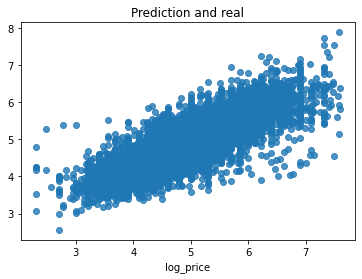

C:\Users\elcor\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



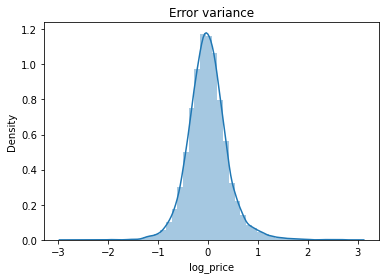

In [40]:
lm = LinearRegression(
        n_jobs = -1,
        normalize = True
)

lm.fit(df_d.drop('log_price', axis = 1), df_d['log_price'])

comment = ''

analysis(
    model = lm, 
    X_train = df_d.drop('log_price', axis = 1), 
    X_test = test.drop('log_price', axis = 1), 
    y_train = df_d['log_price'], 
    y_test = test['log_price']
)

,MAE,MSE,RMSE,RMSE_ratio_test,RMSE_ratio_train,R_2_test,R_2_train
0,0.3,0.16,0.4,0.084,0.077,0.68,0.73


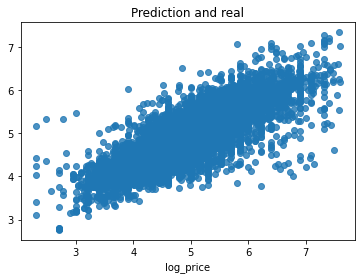

C:\Users\elcor\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



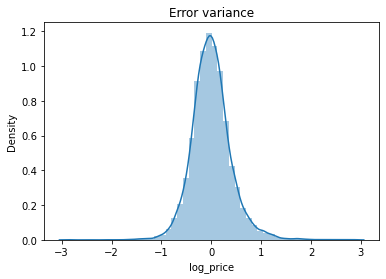

In [41]:
rfm = RandomForestRegressor(
          max_depth = 10,
          n_jobs = -1, 
          random_state = 101,
          n_estimators = 700
    
)
rfm.fit(df_d.drop('log_price', axis = 1), df_d['log_price'])

comment = ''

analysis(
    model = rfm, 
    X_train = df_d.drop('log_price', axis = 1), 
    X_test = test.drop('log_price', axis = 1), 
    y_train = df_d['log_price'], 
    y_test = test['log_price']
)

,MAE,MSE,RMSE,RMSE_ratio_test,RMSE_ratio_train,R_2_test,R_2_train
0,0.3,0.16,0.41,0.085,0.085,0.68,0.68


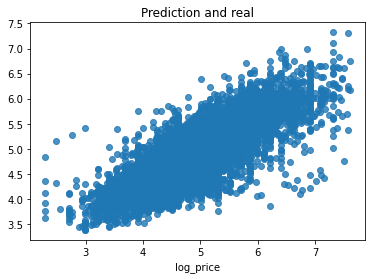

C:\Users\elcor\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



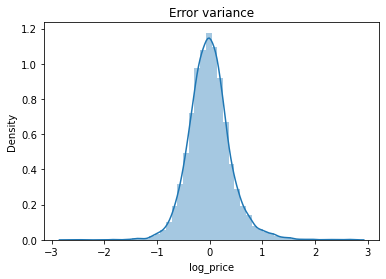

In [42]:
gbr_model = GradientBoostingRegressor(random_state = 101)
gbr_model.fit(df_d.drop('log_price', axis = 1), df_d['log_price'])

comment = ''

analysis(
    model = gbr_model, 
    X_train = df_d.drop('log_price', axis = 1), 
    X_test = test.drop('log_price', axis = 1), 
    y_train = df_d['log_price'], 
    y_test = test['log_price']
)

# Dense neural models

In [43]:
#scaling
scaler = MinMaxScaler()
scaler.fit(df_d.drop('log_price', axis = 1))
X_train_sc = scaler.transform(df_d.drop('log_price', axis = 1).values)
X_test_sc = scaler.transform(test.drop('log_price', axis = 1).values)
y_train = df_d['log_price'].values
y_test = test['log_price'].values

Epoch 1/100
326/326 [==============================] - 1s 1ms/step - loss: 0.8851 - val_loss: 0.2528
Epoch 2/100
326/326 [==============================] - 0s 985us/step - loss: 0.2886 - val_loss: 0.2145
Epoch 3/100
326/326 [==============================] - 0s 1ms/step - loss: 0.2726 - val_loss: 0.1798
Epoch 4/100
326/326 [==============================] - 0s 993us/step - loss: 0.2656 - val_loss: 0.1782
Epoch 5/100
326/326 [==============================] - 0s 997us/step - loss: 0.2615 - val_loss: 0.2024
Epoch 6/100
326/326 [==============================] - 0s 994us/step - loss: 0.2574 - val_loss: 0.1716
Epoch 7/100
326/326 [==============================] - 0s 994us/step - loss: 0.2539 - val_loss: 0.1676
Epoch 8/100
326/326 [==============================] - 0s 994us/step - loss: 0.2481 - val_loss: 0.1748
Epoch 9/100
326/326 [==============================] - 0s 1ms/step - loss: 0.2439 - val_loss: 0.1698
Epoch 10/100
326/326 [==============================] - 0s 1ms/step - loss: 0.2

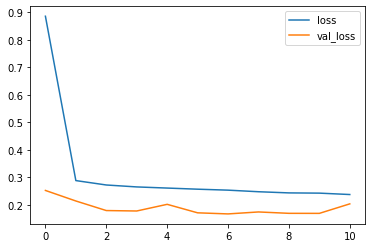

,MAE,MSE,RMSE,RMSE_ratio_test,RMSE_ratio_train,R_2_test,R_2_train
0,0.34,0.2,0.45,0.095,0.094,0.68,0.69


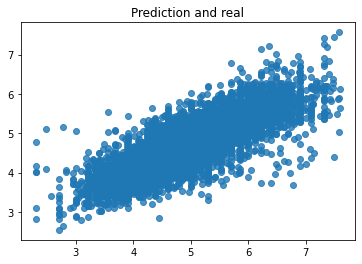

C:\Users\elcor\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



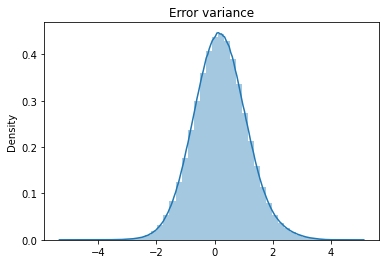

In [44]:
nn_model1 = Sequential()


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)


nn_model1.add(Dense(64, activation = 'relu'))
nn_model1.add(Dropout(0.1))
nn_model1.add(Dense(1))

nn_model1.compile(
    optimizer='rmsprop',
    loss='mse'
)

nn_model1.fit(
    x = X_train_sc,
    y = y_train,
    epochs = 100,
    validation_data=(X_test_sc, y_test), 
    batch_size = 128,
    callbacks=[es]
)


pd.DataFrame(nn_model1.history.history).plot()
plt.show()

analysis(model = nn_model1, 
         X_train = X_train_sc, 
         X_test = X_test_sc, 
         y_train = y_train, 
         y_test = y_test)

# Using text data from 'description' column

In [45]:
df_train['description']

17236    Enjoy a beautiful contemporary residence with ...
58369    My place is close to Don Antonio's, Metro Expo...
44240    Stay one block from Wrigley Field! This renova...
57759    This room is in the lower level of Fort Washin...
40254    Welcome to your home away from home! Cozy priv...
                               ...                        
34345    Nestled under a canopy of oak trees, this 1920...
58878    Our comfortable 2 bedroom apt, centrally locat...
50162        Our lovely apartment has high ceilings and...
49893    Spacious, clean, and flooded with sunlight: Pe...
68913    A simple and sensible apartment ideal for thos...
Name: description, Length: 41686, dtype: object

In [46]:
def del_punct(text):
    chars = [char for char in text if char not in string.punctuation]
    return ''.join(chars)

def del_stopwords(text):
    words = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return words

def text_preparation(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', 'somenumbers', text)
    text = del_stopwords(del_punct(text))
    return text
    
    
text_preparation('Enjoy a beautiful 67 contemporary residence with')

['enjoy', 'beautiful', 'somenumbers', 'contemporary', 'residence']

In [47]:
bow_transformer = CountVectorizer(analyzer = text_preparation, max_features = 1500).fit(df_train['description'])
bow = bow_transformer.transform(df_train['description'])
bow.shape

(41686, 1500)

In [48]:
tfidf_transformer = TfidfTransformer().fit(bow)
train_tfidf = tfidf_transformer.transform(bow)

bow_test = bow_transformer.transform(df_test['description'])
test_tfidf = tfidf_transformer.transform(bow_test)

,MAE,MSE,RMSE,RMSE_ratio_test,RMSE_ratio_train,R_2_test,R_2_train
0,0.47,0.38,0.61,0.129,0.121,0.27,0.35


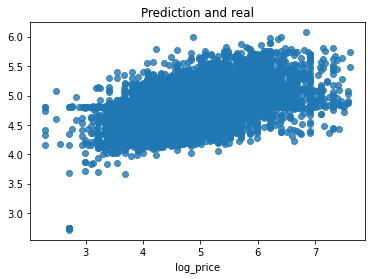

C:\Users\elcor\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



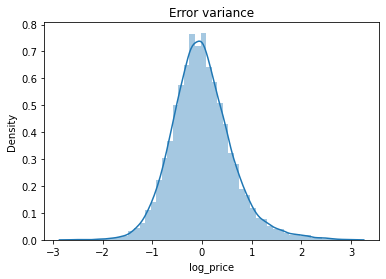

In [49]:
rfm_text = RandomForestRegressor(
    max_depth = 10, 
    n_estimators = 500,
    n_jobs = -1, 
    random_state = 101
)
rfm_text.fit(train_tfidf, df_train['log_price'])

comment = ''

analysis(
    model = rfm_text, 
    X_train = train_tfidf, 
    X_test = test_tfidf, 
    y_train = df_train['log_price'], 
    y_test = df_test['log_price']
)

# We can see that there is not much information in description of object, that can be used for price prediction, but we can try use this in general model. As an experiment we can try to create a model, that would we a stack of 2 models - prediction of text model will be used in model built on all available features as one more feature.

In [50]:
class StackRegression:
    
    def __init__(self, model_general, model_secondary):
        self.model_general = model_general
        self.model_secondary = model_secondary
    
    def fit_predict(self, X_train_general, X_train_secondary, y_train, X_test_general, X_test_secondary, y_test):
        self.model_secondary.fit(X_train_secondary, y_train)
        
        self.secondary_predictions_test =  self.model_secondary.predict(X_test_secondary)
        self.secondary_predictions_train =  self.model_secondary.predict(X_train_secondary)
        
        self.X_train_full = X_train_general.copy()
        self.X_train_full.assign(secondary_model_predictions = self.secondary_predictions_train)
        
        self.X_test_full = X_test_general.copy()
        self.X_test_full.assign(secondary_model_predictions = self.secondary_predictions_test)
                        
        self.model_general.fit(self.X_train_full, y_train)
        
        return self.model_general.predict(self.X_test_full)

,MAE,MSE,RMSE,RMSE_ratio_test,RMSE_ratio_train,R_2_test,R_2_train
0,0.3,0.16,0.4,0.084,0.077,0.68,0.73


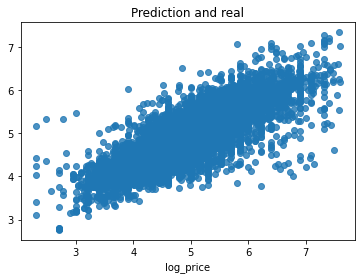

C:\Users\elcor\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



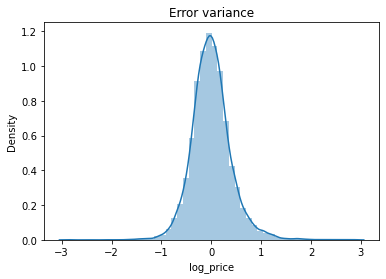

In [51]:
model_general = RandomForestRegressor(
          max_depth = 10,
          n_jobs = -1, 
          random_state = 101,
          n_estimators = 700
    
)

model_for_text = RandomForestRegressor(
          max_depth = 10,
          n_jobs = -1, 
          random_state = 101,
          n_estimators = 700
    
)

stack_model = StackRegression(model_general, model_for_text)


prediction_test = stack_model.fit_predict(
    X_train_general = df_d.drop('log_price', axis = 1), 
    X_train_secondary = train_tfidf, 
    y_train = df_d['log_price'], 
    X_test_general = test.drop('log_price', axis = 1), 
    X_test_secondary = test_tfidf, 
    y_test = test['log_price']
)

prediction_train = stack_model.fit_predict(
    X_train_general = df_d.drop('log_price', axis = 1), 
    X_train_secondary = train_tfidf, 
    y_train = df_d['log_price'], 
    X_test_general = df_d.drop('log_price', axis = 1), 
    X_test_secondary = train_tfidf, 
    y_test = df_d['log_price']
)

show_metrics(prediction_test, prediction_train, y_test = test['log_price'], y_train = df_d['log_price'])


sns.regplot(x = test['log_price'], y = prediction_test, fit_reg=False)
plt.title('Prediction and real')
plt.show()

sns.distplot(test['log_price'] - prediction_test, bins = 50)
plt.title('Error variance')
plt.show()

# This model doesn't have an advantage over more simple models. So for final submission I prefer to use just simple RFR

# Validation

In [52]:
val_data_for_model = columns_standardization(processing(validation_df))
val_data_for_model

<ipython-input-34-a4d80b5333c2>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,review_scores_rating,number_of_reviews,longitude,log_price,latitude,instant_bookable,host_since,host_response_rate,host_identity_verified,host_has_profile_pic,dum: room_type: Shared room,dum: room_type: Private room,dum: property_type: other,dum: property_type: Villa,dum: property_type: Townhouse,dum: property_type: Other,dum: property_type: Loft,dum: property_type: House,dum: property_type: Guesthouse,dum: property_type: Guest suite,dum: property_type: Dorm,dum: property_type: Condominium,dum: property_type: Camper/RV,dum: property_type: Bungalow,dum: property_type: Bed & Breakfast,dum: neighbourhood: no data,dum: neighbourhood: Wrigleyville,dum: neighbourhood: Woodside,dum: neighbourhood: Woodridge,dum: neighbourhood: Woodley Park,dum: neighbourhood: Woodlawn,dum: neighbourhood: Woodland Hills/Warner Center,dum: neighbourhood: Woodland,dum: neighbourhood: Woodhaven,dum: neighbourhood: Winthrop,dum: neighbourhood: Winnetka,dum: neighbourhood: Windsor Terrace,dum: neighbourhood: Wilmington,dum: neighbourhood: Williamsburg,dum: neighbourhood: Williamsbridge,dum: neighbourhood: Wicker Park,dum: neighbourhood: Whittier,dum: neighbourhood: Whitestone,dum: neighbourhood: Westwood,dum: neighbourhood: Westside,dum: neighbourhood: Westlake,dum: neighbourhood: Western Addition/NOPA,dum: neighbourhood: Westerleigh,dum: neighbourhood: Westchester/Playa Del Rey,dum: neighbourhood: Westchester Village,dum: neighbourhood: West Village,dum: neighbourhood: West Town/Noble Square,dum: neighbourhood: West Town,dum: neighbourhood: West Roxbury,dum: neighbourhood: West Ridge,dum: neighbourhood: West Puente Valley,dum: neighbourhood: West Portal,dum: neighbourhood: West Los Angeles,dum: neighbourhood: West Loop/Greektown,dum: neighbourhood: West Lawn,dum: neighbourhood: West Hollywood,dum: neighbourhood: West Hills,dum: neighbourhood: West Farms,dum: neighbourhood: West End,dum: neighbourhood: West Elsdon,dum: neighbourhood: West Covina,dum: neighbourhood: West Brighton,dum: neighbourhood: West Athens,dum: neighbourhood: West Adams,dum: neighbourhood: Wesley Heights,dum: neighbourhood: Watts,dum: neighbourhood: Watertown,dum: neighbourhood: Washington Park,dum: neighbourhood: Washington Highlands,dum: neighbourhood: Washington Heights,dum: neighbourhood: Wakefield,dum: neighbourhood: Visitacion Valley,dum: neighbourhood: Vinegar Hill,dum: neighbourhood: Venice,dum: neighbourhood: Van Nuys,dum: neighbourhood: Van Nest,dum: neighbourhood: Valley Village,dum: neighbourhood: Valley Glen,dum: neighbourhood: Utopia,dum: neighbourhood: Uptown,dum: neighbourhood: Upper West Side,dum: neighbourhood: Upper East Side,dum: neighbourhood: University Heights,dum: neighbourhood: Union Square,dum: neighbourhood: Ukrainian Village,dum: neighbourhood: U Street Corridor,dum: neighbourhood: Twining,dum: neighbourhood: Twin Peaks,dum: neighbourhood: Truxton Circle,dum: neighbourhood: Trinidad,dum: neighbourhood: Tribeca,dum: neighbourhood: Tremont,dum: neighbourhood: Tottenville,dum: neighbourhood: Torrance,dum: neighbourhood: Topanga,dum: neighbourhood: Tompkinsville,dum: neighbourhood: Toluca Lake,dum: neighbourhood: Times Square/Theatre District,dum: neighbourhood: Throgs Neck,dum: neighbourhood: Theater District,dum: neighbourhood: The Rockaways,dum: neighbourhood: The Castro,dum: neighbourhood: The Bronx,dum: neighbourhood: Tenderloin,dum: neighbourhood: Temple City,dum: neighbourhood: Telegraph Hill,dum: neighbourhood: Tarzana,"dum: neighbourhood: Takoma Park, MD",dum: neighbourhood: Takoma,dum: neighbourhood: Sylmar,dum: neighbourhood: Sunset Park,dum: neighbourhood: Sunnyside,dum: neighbourhood: Sunland/Tujunga,dum: neighbourhood: Sun Valley,"dum: neighbourhood: Suitland-Silver Hill, MD",dum: neighbourhood: Studio City,dum: neighbourhood: Stronghold,dum: neighbourhood: Streeterville,dum: neighbourhood: Stapleton,dum: neighbourhood: St. George,dum: neighbourhood: St. Elizabeths,dum: neighbourhood: Spuyten Duyvil,dum: neighbourhood: Spring Valley,dum: neighbour

In [53]:
val_data_for_model[val_data_for_model.isnull().any(axis=1)]

,review_scores_rating,number_of_reviews,longitude,log_price,latitude,instant_bookable,host_since,host_response_rate,host_identity_verified,host_has_profile_pic,dum: room_type: Shared room,dum: room_type: Private room,dum: property_type: other,dum: property_type: Villa,dum: property_type: Townhouse,dum: property_type: Other,dum: property_type: Loft,dum: property_type: House,dum: property_type: Guesthouse,dum: property_type: Guest suite,dum: property_type: Dorm,dum: property_type: Condominium,dum: property_type: Camper/RV,dum: property_type: Bungalow,dum: property_type: Bed & Breakfast,dum: neighbourhood: no data,dum: neighbourhood: Wrigleyville,dum: neighbourhood: Woodside,dum: neighbourhood: Woodridge,dum: neighbourhood: Woodley Park,dum: neighbourhood: Woodlawn,dum: neighbourhood: Woodland Hills/Warner Center,dum: neighbourhood: Woodland,dum: neighbourhood: Woodhaven,dum: neighbourhood: Winthrop,dum: neighbourhood: Winnetka,dum: neighbourhood: Windsor Terrace,dum: neighbourhood: Wilmington,dum: neighbourhood: Williamsburg,dum: neighbourhood: Williamsbridge,dum: neighbourhood: Wicker Park,dum: neighbourhood: Whittier,dum: neighbourhood: Whitestone,dum: neighbourhood: Westwood,dum: neighbourhood: Westside,dum: neighbourhood: Westlake,dum: neighbourhood: Western Addition/NOPA,dum: neighbourhood: Westerleigh,dum: neighbourhood: Westchester/Playa Del Rey,dum: neighbourhood: Westchester Village,dum: neighbourhood: West Village,dum: neighbourhood: West Town/Noble Square,dum: neighbourhood: West Town,dum: neighbourhood: West Roxbury,dum: neighbourhood: West Ridge,dum: neighbourhood: West Puente Valley,dum: neighbourhood: West Portal,dum: neighbourhood: West Los Angeles,dum: neighbourhood: West Loop/Greektown,dum: neighbourhood: West Lawn,dum: neighbourhood: West Hollywood,dum: neighbourhood: West Hills,dum: neighbourhood: West Farms,dum: neighbourhood: West End,dum: neighbourhood: West Elsdon,dum: neighbourhood: West Covina,dum: neighbourhood: West Brighton,dum: neighbourhood: West Athens,dum: neighbourhood: West Adams,dum: neighbourhood: Wesley Heights,dum: neighbourhood: Watts,dum: neighbourhood: Watertown,dum: neighbourhood: Washington Park,dum: neighbourhood: Washington Highlands,dum: neighbourhood: Washington Heights,dum: neighbourhood: Wakefield,dum: neighbourhood: Visitacion Valley,dum: neighbourhood: Vinegar Hill,dum: neighbourhood: Venice,dum: neighbourhood: Van Nuys,dum: neighbourhood: Van Nest,dum: neighbourhood: Valley Village,dum: neighbourhood: Valley Glen,dum: neighbourhood: Utopia,dum: neighbourhood: Uptown,dum: neighbourhood: Upper West Side,dum: neighbourhood: Upper East Side,dum: neighbourhood: University Heights,dum: neighbourhood: Union Square,dum: neighbourhood: Ukrainian Village,dum: neighbourhood: U Street Corridor,dum: neighbourhood: Twining,dum: neighbourhood: Twin Peaks,dum: neighbourhood: Truxton Circle,dum: neighbourhood: Trinidad,dum: neighbourhood: Tribeca,dum: neighbourhood: Tremont,dum: neighbourhood: Tottenville,dum: neighbourhood: Torrance,dum: neighbourhood: Topanga,dum: neighbourhood: Tompkinsville,dum: neighbourhood: Toluca Lake,dum: neighbourhood: Times Square/Theatre District,dum: neighbourhood: Throgs Neck,dum: neighbourhood: Theater District,dum: neighbourhood: The Rockaways,dum: neighbourhood: The Castro,dum: neighbourhood: The Bronx,dum: neighbourhood: Tenderloin,dum: neighbourhood: Temple City,dum: neighbourhood: Telegraph Hill,dum: neighbourhood: Tarzana,"dum: neighbourhood: Takoma Park, MD",dum: neighbourhood: Takoma,dum: neighbourhood: Sylmar,dum: neighbourhood: Sunset Park,dum: neighbourhood: Sunnyside,dum: neighbourhood: Sunland/Tujunga,dum: neighbourhood: Sun Valley,"dum: neighbourhood: Suitland-Silver Hill, MD",dum: neighbourhood: Studio City,dum: neighbourhood: Stronghold,dum: neighbourhood: Streeterville,dum: neighbourhood: Stapleton,dum: neighbourhood: St. George,dum: neighbourhood: St. Elizabeths,dum: neighbourhood: Spuyten Duyvil,dum: neighbourhood: Spring Valley,dum: neighbour

,MAE,MSE,RMSE,RMSE_ratio_test,RMSE_ratio_train,R_2_test,R_2_train
0,0.3,0.17,0.41,0.085,0.077,0.68,0.73


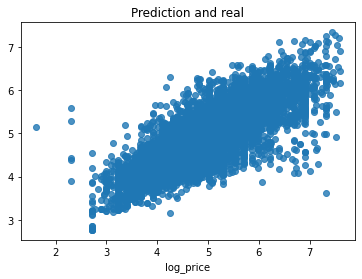

C:\Users\elcor\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



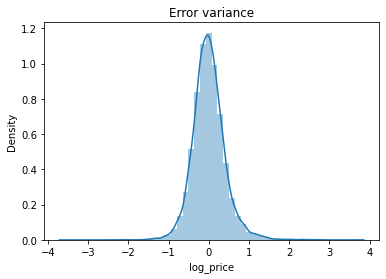

In [54]:
analysis(
    model = rfm, 
    X_train = df_d.drop('log_price', axis = 1), 
    X_test = val_data_for_model.drop('log_price', axis = 1), 
    y_train = df_d['log_price'], 
    y_test = val_data_for_model['log_price']
)